In [1]:
# --- Librerie Standard e Utilità ---
import os
import json
import random
import numpy as np
from tqdm import tqdm

# --- Machine Learning e Processamento Dati ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# --- Ottimizzazione e Monitoraggio ---
import optuna
import wandb

# --- Moduli Personalizzati ---
from training_utils import *
from testing_utils import *
from plotting_utils import *

In [2]:
with open('./remote_results/UTS/UTS_4612312_info.json', 'r') as file:
    data = json.loads(file.read())

In [3]:
data['data'][0]

{'id': 6,
 'success': True,
 'collisions': 0,
 'reward': 11.516666412353516,
 'length': 117,
 'seed': 123459,
 'distance_traveled': 2.335279941558838,
 'global_avg_dist_obstacle': 3.586725950241089,
 'global_avg_visibility': 12.266192436218262,
 'global_avg_dispersion': 8.831521034240723,
 'global_characteristic_dimension': 11.721299171447754,
 'path_tortuosity': 1.0,
 'path_length': 8.158431053161621}

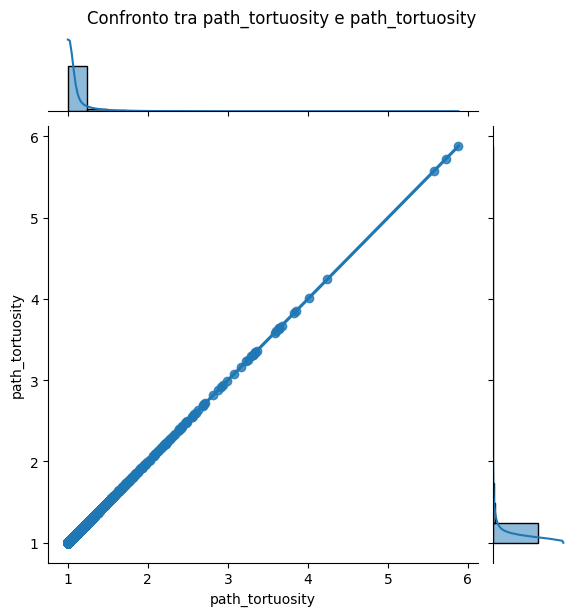

In [7]:
plot_confronto_metriche(data['data'], 'path_tortuosity', 'path_tortuosity' )